## Metadata Analysis

Exploratory data analysis on comic book images and metadata scraped from `https://comics.org`.

In [16]:
import os
import pandas as pd
from PIL import Image

from comics_net import analyzer

Describe the issue metadata of all comic books scraped thus far.

In [4]:
# load the metadata
df = analyzer.load_metadata('../metadata/covers.jsonl')

# parse issue number and cast as int
df['issue_number'] = df['title'].apply(analyzer.get_issue_number_from_title)

# describe categorical metadata features
df.drop(['issue_number', 'covers'], axis=1).describe().T

,count,unique,top,freq
format_binding,50956,104,Saddle-stitched,20484
format_color,50956,45,Color,26981
format_dimensions,50956,133,Standard Modern Age US,10243
format_paper_stock,50956,157,,13056
format_publishing_format,50956,79,was ongoing series,19589
indexer_notes,50956,29053,,10764
indicia_frequency,50956,843,monthly,24585
issue_brand,50956,193,DC [bullet],9953
issue_indicia_publisher,50956,119,DC Comics,13987
issue_pages,50956,156,36,34921


## Character Labels

Each comic book contains some issue metadata (as shown above) in addition to a metadata for each of the "covers", as some issues contain variant covers.

Below we unpack the covers metadata and parse the list of characters appearing on each cover (and variant).

In [38]:
# create cover df
df_covers = pd.concat(df['covers'].apply(lambda x: pd.DataFrame(x).T).tolist(), axis=0)

# create cover characters df
df_cover_characters = df_covers[df_covers["cover_characters"].notnull()].reset_index(drop=True).copy()

# convert cover_characters string to list
df_cover_characters["cover_characters_list"] = df_cover_characters["cover_characters"].apply(analyzer.convert_characters_to_list)

all_characters_instances = pd.Series(analyzer.flatten(df_cover_characters["cover_characters_list"].values))
print("Top {} of {} unique characters".format(50, len(all_characters_instances.unique())))

list(zip(pd.Series(analyzer.flatten(df_cover_characters["cover_characters_list"].values)).value_counts()[:50].index,
         pd.Series(analyzer.flatten(df_cover_characters["cover_characters_list"].values)).value_counts()[:50].values))

Top 50 of 21869 unique characters


[('Batman [Bruce Wayne]', 2750),
 ('Superman', 2310),
 ('Batman', 2059),
 ('Spider-Man [Peter Parker]', 2034),
 ('Iron Man [Tony Stark]', 1346),
 ('Wolverine', 1337),
 ('Captain America [Steve Rogers]', 1203),
 ('Thor', 1173),
 ('Wonder Woman', 948),
 ('Robin [Dick Grayson]', 938),
 ('Hulk [Bruce Banner]', 923),
 ('Spider-Man', 904),
 ('Superman [Clark Kent/ Kal-El]', 864),
 ('Human Torch [Johnny Storm]', 790),
 ('Green Lantern [Hal Jordan]', 753),
 ('Cyclops', 722),
 ('Superman [Clark Kent]', 629),
 ('Flash [Barry Allen]', 581),
 ('Deadpool', 575),
 ('Storm', 553),
 ('Superboy', 541),
 ('Conan', 531),
 ('Lois Lane', 519),
 ('Hulk', 491),
 ('Beast', 490),
 ('Vision', 487),
 ('Flash [Wally West]', 483),
 ('Green Arrow [Oliver Queen]', 472),
 ('Aquaman', 459),
 ('Robin [Tim Drake]', 403),
 ('Joker', 402),
 ('Colossus', 401),
 ('Iceman', 387),
 ('Mr. Fantastic', 382),
 ('Wonder Woman [Diana Prince]', 356),
 ('Iron Man', 356),
 ('The Thing', 345),
 ('Catwoman [Selina Kyle]', 333),
 ('The T

In [39]:
from comics_net.webscraper import strip_brackets

unique_characters = pd.Series(analyzer.flatten(df_cover_characters["cover_characters_list"].values)).value_counts().index

# create character alias dict
aliases = {k: v for k, v in zip(unique_characters, [strip_brackets(x) for x in unique_characters])}

# apply aliases to character names
df_cover_characters["cover_characters_list_aliases"] = df_cover_characters["cover_characters_list"].apply(lambda x: [aliases[i] for i in x])

# create character count dict
character_counts = {k: v for k, v in 
                    zip(pd.Series(analyzer.flatten(df_cover_characters["cover_characters_list_aliases"].values)).value_counts().index,
                        pd.Series(analyzer.flatten(df_cover_characters["cover_characters_list_aliases"].values)).value_counts().values)}

In [17]:
covers = os.listdir('../covers/')

dims = []
for cover in covers:
    im = Image.open('../covers/' + cover)
    width, height = im.size
    dims.append((width, height))
    
"Calculated dims for {} covers".format(len(dims))

'Calculated dims for 61136 covers'

In [58]:
n = 60
pct = pd.Series(pd.Series(dims).value_counts() / len(dims)).cumsum()[:n].tail(1).values[0] * 100
print('Top {} image sizes account for {}% of covers'.format(n, round(pct, 1)), '\n')

top_dims = pd.Series(pd.Series(dims).value_counts() / len(dims)).cumsum()[:n].index
top_dims

print('Top Image Sizes:')
print(top_dims.values, '\n')
print('Height distribution:')
print('mean', round(pd.Series(map(lambda x: x[1], top_dims)).mean(), 0))
print('median', round(pd.Series(map(lambda x: x[1], top_dims)).median(), 0))
print('min', round(pd.Series(map(lambda x: x[1], top_dims)).min(), 0))
print('max', round(pd.Series(map(lambda x: x[1], top_dims)).max(), 0))
print('std', round(pd.Series(map(lambda x: x[1], top_dims)).std(), 0))

Top 60 image sizes account for 94.2% of covers 

Top Image Sizes:
[(400, 615) (400, 616) (400, 614) (400, 618) (400, 617) (400, 613)
 (400, 619) (400, 612) (400, 607) (400, 620) (400, 611) (400, 610)
 (400, 621) (400, 608) (400, 622) (400, 606) (400, 609) (400, 623)
 (400, 624) (400, 604) (400, 600) (400, 605) (400, 603) (400, 601)
 (400, 602) (400, 625) (400, 598) (400, 596) (400, 626) (400, 597)
 (400, 599) (400, 594) (400, 595) (400, 591) (400, 593) (400, 627)
 (400, 628) (400, 590) (400, 592) (400, 588) (400, 589) (400, 587)
 (400, 586) (400, 584) (400, 585) (400, 583) (400, 629) (400, 634)
 (400, 581) (400, 579) (400, 582) (400, 578) (400, 580) (400, 546)
 (400, 630) (400, 577) (400, 576) (400, 574) (400, 575) (400, 573)] 

Height distribution:
mean 601.0
median 602.0
min 546
max 634
std 19.0


### Show a random comic book cover

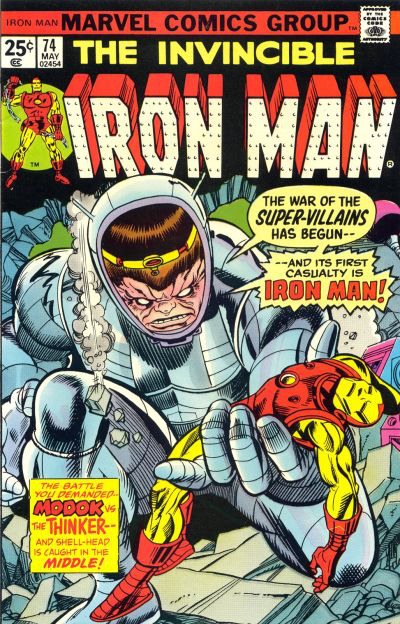

In [41]:
random_cover = analyzer.get_random_sample_of_covers(df_cover_characters, character="Iron Man", n=1)

image_path = random_cover[list(random_cover.keys())[0]]["image_path"]
im = Image.open("." + image_path)
im

In [60]:
# learnings from examining random covers

# 1) exclude (inset) characters from labels??? or include them, as (inset)??? inset characters or not prominently featured on  the cover 
# but usually just shown as a head in a banner, or something like that.

# 2) there is some amount of label noise - variant covers do not always have characters labeled 
# (sometimes they inherit the character list from the original cover)

#3) there is also an amount of unlabeld covers, which can be easily labeled

In [63]:
# def get_value_counts(df, column):
#     return pd.Series("; ".join(df[column].\
#                                dropna()).\
#                      replace(" (signed)", "").\
#                      replace(" (painted)", "").\
#                      split('; ')).value_counts()

# print("Cover Artists:")

# list(zip(get_value_counts(df_covers, 'cover_pencils')[:100].index, 
#          get_value_counts(df_covers, 'cover_pencils')[:100].values))

In [43]:
print("Top {} of {} unique characters".format(50, len(character_counts.keys())))

[(k, character_counts[k]) for k in character_counts.keys()][:50]

Top 50 of 17720 unique characters


[('Batman', 5270),
 ('Superman', 3986),
 ('Spider-Man', 3108),
 ('Green Lantern', 2500),
 ('Robin', 1948),
 ('Iron Man', 1808),
 ('Thor', 1720),
 ('Captain America', 1691),
 ('Wonder Woman', 1588),
 ('Flash', 1519),
 ('Wolverine', 1505),
 ('Hulk', 1477),
 ('Human Torch', 1226),
 ('Superboy', 1000),
 ('Cyclops', 863),
 ('Green Arrow', 745),
 ('Deadpool', 745),
 ('The Thing', 697),
 ('Aquaman', 675),
 ('Storm', 647),
 ('Supergirl', 639),
 ('Hawkeye', 628),
 ('Beast', 626),
 ('Mr. Fantastic', 624),
 ('Catwoman', 609),
 ('Captain Marvel', 599),
 ('Hawkman', 581),
 ('Nightwing', 535),
 ('Conan', 531),
 ('Lois Lane', 521),
 ('Scarlet Witch', 506),
 ('Iceman', 498),
 ('Black Canary', 496),
 ('Vision', 495),
 ('Doctor Strange', 481),
 ('Colossus', 480),
 ('Black Panther', 478),
 ('Batgirl', 439),
 ('Wasp', 435),
 ('Martian Manhunter', 433),
 ('Wonder Girl', 427),
 ('The Flash', 414),
 ('Cyborg', 413),
 ('Rogue', 411),
 ('Joker', 405),
 ('Angel', 400),
 ('Black Widow', 388),
 ('Invisible Girl',

In [ ]:
# characters and number of covers to include in training set
characters_dict = {"Superman": 3100,
                   "Batman": 3800,
                   "Green Lantern": 2200,
                   "Wonder Woman": 1400, 
                   "Flash": 1350, 
                   "Aquaman": 550,
                   "Cyborg": 300}

analyzer.create_training_dirs(save_dir="justice_league", characters_dict=characters_dict)

In [44]:
# # # TODO: load metadata and return aggregate / summary statistics

# logged_metadata = []

# with jsonlines.open('../metadata/log.jsonl', mode='r') as reader:
#     for item in reader:
#         logged_metadata.append(item)
        
# log = pd.DataFrame(logged_metadata)

# log[["issue_count", "publisher_id", "publisher_page"]] = log[["issue_count", "publisher_id", "publisher_page"]].astype(int)

# sorted_log = log.\
# drop_duplicates().\
# sort_values(by=["publisher_id",  "publisher_page", "series"])\
# [["publisher_id",  "publisher_page", "series", "issue_count"]]

In [45]:
# sorted_log[sorted_log["publisher_id"] == 78][20:]